In [2]:

import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
input_shape = (224, 224, 3)
num_classes = 4
batch_size = 32
epochs = 50
lr = 0.001

In [4]:
# Set the paths to the training, test and validation data directories
train_dir = 'data/MSID_US_AUG_SP/train'
val_dir = 'data/MSID_US_AUG_SP/val'

In [6]:
# Create an instance of the ImageDataGenerator class for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

# Create an instance of the ImageDataGenerator class for validation data (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)


# Load the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
)

# Load the validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
)

train_generator.classes


Found 3618 images belonging to 4 classes.
Found 1033 images belonging to 4 classes.


array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [5]:
# Load the MobileNetV2 model with pre-trained weights on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a dense layer with 128 neurons and ReLU activation
x = Dense(128, activation='relu')(x)

# Add a final dense layer with 4 neurons (one for each class) and softmax activation
predictions = Dense(4, activation='softmax')(x)

# Create the new model with the modified architecture
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the weights of the base model to avoid overfitting on small datasets
for layer in base_model.layers:
    layer.trainable = False
    
optimizier = tf.keras.optimizers.Adam(learning_rate=lr)
                                    
                                    
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [34]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [6]:
# Set up the learning rate schedule
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7)


# Train the model using fit_generator with the learning rate schedule
model.fit(
    train_generator, 
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_generator, 
    callbacks=[reduce_lr], 
    verbose=1)


Epoch 1/50


2023-06-09 19:37:14.587052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-09 19:37:14.591076: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


114/114 [==============================] - ETA: 0s - loss: 0.5010 - accuracy: 0.8154

2023-06-09 19:37:34.631090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


114/114 [==============================] - 26s 218ms/step - loss: 0.5010 - accuracy: 0.8154 - val_loss: 0.3484 - val_accuracy: 0.8809 - lr: 0.0010
Epoch 2/50
114/114 [==============================] - 25s 217ms/step - loss: 0.1753 - accuracy: 0.9420 - val_loss: 0.2590 - val_accuracy: 0.9109 - lr: 0.0010
Epoch 3/50
114/114 [==============================] - 25s 218ms/step - loss: 0.0878 - accuracy: 0.9773 - val_loss: 0.1642 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 4/50
114/114 [==============================] - 25s 221ms/step - loss: 0.0473 - accuracy: 0.9906 - val_loss: 0.1165 - val_accuracy: 0.9603 - lr: 0.0010
Epoch 5/50
114/114 [==============================] - 26s 226ms/step - loss: 0.0273 - accuracy: 0.9953 - val_loss: 0.1251 - val_accuracy: 0.9535 - lr: 0.0010
Epoch 6/50
114/114 [==============================] - 26s 231ms/step - loss: 0.0158 - accuracy: 0.9992 - val_loss: 0.1146 - val_accuracy: 0.9593 - lr: 0.0010
Epoch 7/50
114/114 [==============================] - 27s 237ms

Found 521 images belonging to 4 classes.


2023-06-09 20:04:01.698946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


521/521 [==============================] - 9s 17ms/step
Metric              Value               
----------------------------------------
F1 Score            0.9789              
Test Accuracy       0.9789              
Precision           0.9792              
Recall              0.9789              


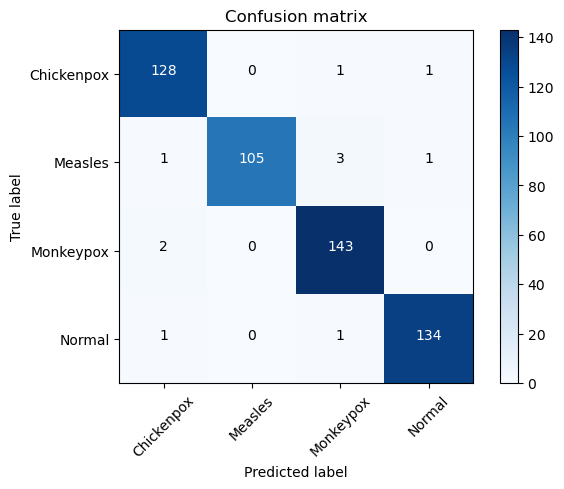

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import itertools

test_dir = 'data/MSID_US_AUG_SP/test'

# Create an instance of the ImageDataGenerator class for test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=1,
    class_mode='categorical',
    shuffle= False
)


# Use the test generator to generate predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels
y_true = test_generator.classes


# Calculate the evaluation metrics
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)


# Define the evaluation metrics
metrics = ['F1 Score', 'Test Accuracy', 'Precision', 'Recall']
values = [f1,accuracy, precision, recall]

# Print the metrics in a table format
print('{:<20s}{:<20s}'.format('Metric', 'Value'))
print('-' * 40)
for metric, value in zip(metrics, values):
    print('{:<20s}{:<20.4f}'.format(metric, value))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define the class names
class_names = list(test_generator.class_indices.keys())

# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plt.figure()
plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False, title='Confusion matrix')
plt.show()


In [11]:
model.save('models/mobilenetv2_ultra_yuka.h5')

In [3]:
model = tf.keras.models.load_model('models/mobilenetv2_ultra_yuka.h5')

In [4]:
import cv2
import numpy as np

image = cv2.imread('test-images/normal-test.jpeg')

# Resize the image to the input size expected by the model
input_size = (224, 224)  # example input size for a model
image = cv2.resize(image, input_size)

# Convert the image to a NumPy array
image = np.array(image)

# Scale the pixel values to be between 0 and 1
image = image / 255.0

# Add an extra dimension to the array to represent the batch size (1 in this case)
image = np.expand_dims(image, axis=0)



prediction = model.predict(image)

predicted_class = np.argmax(prediction)


print(predicted_class)

ModuleNotFoundError: No module named 'cv2'